# Regularized Logistic Regression

This notebook contains the second part of Programming Exercise 2 of the Andrew Ng's course on Coursera.

Implement a classification model using Regularized Logistic Regression to predict whether a chip is accepted or not. We will make the decision based on the score obtained in two tests. We have historical data about the score of other chips in such two tests and whether they were accepted or not.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [216]:
# load data
import os
data_original = pd.read_csv(os.getcwd() + '/ex2data2.txt', header=None, names=['Test 1', 'Test 2', 'Accepted'])

### Explore data

In [217]:
data_original.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [218]:
data_original.describe()

,Test 1,Test 2,Accepted
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646562,1.000000
max,1.070900,1.108900,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119f6a908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a52e630>]], dtype=object)

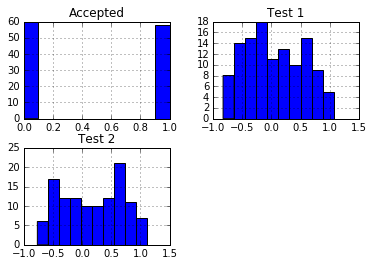

In [219]:
data_original.hist()

In [220]:
# let's separate the two types of classes and explore them separatedly
accepted = data_original[data_original['Accepted']==1]
rejected = data_original[data_original['Accepted']==0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a599160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a8d7438>]], dtype=object)

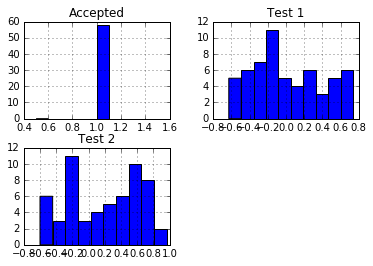

In [221]:
accepted.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a8ad828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11adcd3c8>]], dtype=object)

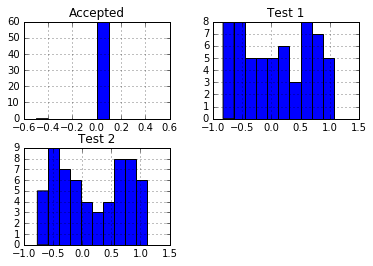

In [222]:
rejected.hist()

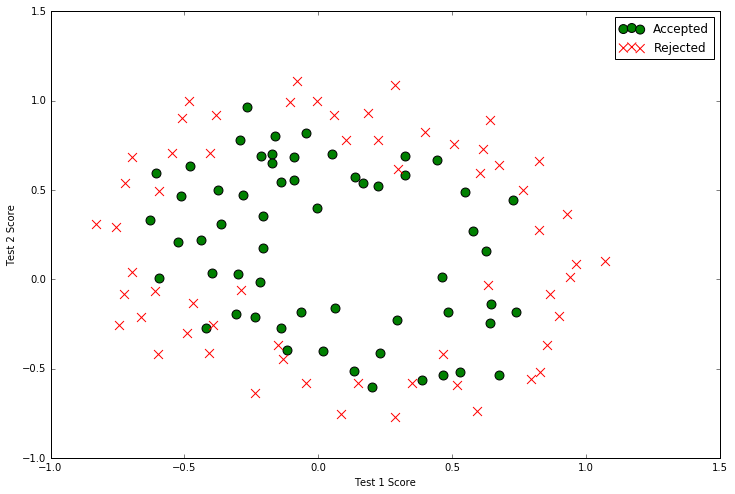

In [223]:
# scatter plot to visualize the data
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(accepted['Test 1'], accepted['Test 2'], s=80, c='g', marker='o', label='Accepted')
ax.scatter(rejected['Test 1'], rejected['Test 2'], s=80, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

This scatter plot indicates that there is no a clear linear decision boundary that will work well on this data and hence a linear Logisitic Regression model will not be a good classifier. 

## Feature engineering

We will have to to use a more complex model with additional features created from polynomials of the original features.

[x1, x2, x1^2, x1 * x2, x2^2, x1^3, x1^2 * x2, x1 * x2^2, x2^3 ... x1^6, x1^5 * x2, x1^4 * x2^2, x1^3 * x2^3, x1^2 * x2^4, x1 * x2^5, x2^6]


In [548]:
data = data_original.copy()

In [549]:
data.drop('Test 1', axis=1, inplace=True)
data.drop('Test 2', axis=1, inplace=True)
data.head()

,Accepted
0,1
1,1
2,1
3,1
4,1


In [550]:
# create the polynomial features as Fxy
degree = 10
for i in range(1, degree+1):
    for j in range(0, i+1):
        data['F' + str(i) + str(j)] = np.power(data_original['Test 1'], i-j) * np.power(data_original['Test 2'], j)
data.insert(1, 'Ones', 1)
data.columns

Index(['Accepted', 'Ones', 'F10', 'F11', 'F20', 'F21', 'F22', 'F30', 'F31',
       'F32', 'F33', 'F40', 'F41', 'F42', 'F43', 'F44', 'F50', 'F51', 'F52',
       'F53', 'F54', 'F55', 'F60', 'F61', 'F62', 'F63', 'F64', 'F65', 'F66',
       'F70', 'F71', 'F72', 'F73', 'F74', 'F75', 'F76', 'F77', 'F80', 'F81',
       'F82', 'F83', 'F84', 'F85', 'F86', 'F87', 'F88', 'F90', 'F91', 'F92',
       'F93', 'F94', 'F95', 'F96', 'F97', 'F98', 'F99', 'F100', 'F101', 'F102',
       'F103', 'F104', 'F105', 'F106', 'F107', 'F108', 'F109', 'F1010'],
      dtype='object')

In [551]:
data.head()

,Accepted,Ones,F10,F11,F20,F21,F22,F30,F31,F32,...,F101,F102,F103,F104,F105,F106,F107,F108,F109,F1010
0,1,1,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,...,1.711457e-12,2.335356e-11,3.186693e-10,4.348378e-09,5.933547e-08,8.096577e-07,0.000011,0.000151,0.002057,0.028070
1,1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,...,-3.476487e-10,2.567537e-09,-1.896238e-08,1.400454e-07,-1.034296e-06,7.638727e-06,-0.000056,0.000417,-0.003077,0.022726
2,1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,...,-6.437045e-07,2.085089e-06,-6.754027e-06,2.187766e-05,-7.086618e-05,2.295499e-04,-0.000744,0.002409,-0.007802,0.025271
3,1,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,...,-7.364605e-05,9.862483e-05,-1.320757e-04,1.768723e-04,-2.368627e-04,3.172002e-04,-0.000425,0.000569,-0.000762,0.001020
4,1,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,...,-1.150829e-03,1.044076e-03,-9.472259e-04,8.593595e-04,-7.796437e-04,7.073226e-04,-0.000642,0.000582,-0.000528,0.000479


In [552]:
data.describe()

,Accepted,Ones,F10,F11,F20,F21,F22,F30,F31,F32,...,F101,F102,F103,F104,F105,F106,F107,F108,F109,F1010
count,118.000000,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,...,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02
mean,0.491525,1.0,0.054779,0.183102,0.247575,-0.025472,0.301370,5.983333e-02,0.030682,0.015483,...,1.666277e-03,5.318746e-03,1.034778e-04,3.040300e-03,6.883363e-05,3.728850e-03,-5.005615e-04,9.919896e-03,-3.464200e-03,1.020867e-01
std,0.502060,0.0,0.496654,0.519743,0.248532,0.224075,0.284536,2.746459e-01,0.134706,0.150143,...,3.270108e-02,1.401976e-02,1.037912e-02,8.199982e-03,8.999227e-03,1.086785e-02,1.787292e-02,3.239311e-02,8.460621e-02,3.722619e-01
min,0.000000,1.0,-0.830070,-0.769740,0.000040,-0.484096,0.000026,-5.719317e-01,-0.358121,-0.483743,...,-9.629816e-02,4.154654e-19,-3.807164e-02,1.654413e-15,-2.658637e-02,2.233143e-15,-1.131167e-01,1.657812e-19,-4.812764e-01,1.230706e-23
25%,0.000000,1.0,-0.372120,-0.254385,0.043243,-0.178209,0.061086,-5.155632e-02,-0.023672,-0.042980,...,-2.499491e-04,3.190712e-07,-1.292165e-04,4.926304e-07,-1.886999e-04,1.372054e-06,-3.813760e-04,1.261911e-06,-1.980744e-03,8.750001e-07
50%,0.000000,1.0,-0.006336,0.213455,0.165397,-0.016521,0.252195,-2.544062e-07,0.006603,-0.000039,...,-2.358636e-10,7.528015e-05,-7.169183e-09,3.952184e-05,-1.601372e-09,6.938687e-05,-4.489879e-09,2.349402e-04,-9.687178e-09,1.020189e-03
75%,1.000000,1.0,0.478970,0.646562,0.389925,0.100795,0.464189,1.099616e-01,0.086392,0.079510,...,1.990047e-05,2.657392e-03,1.300154e-05,1.488900e-03,1.040952e-05,1.535721e-03,1.705464e-05,3.727489e-03,2.585553e-05,2.162350e-02
max,1.000000,1.0,1.070900,1.108900,1.146827,0.568307,1.229659,1.228137e+00,0.449251,0.505577,...,1.855202e-01,9.266468e-02,7.463629e-02,6.011542e-02,5.928096e-02,8.255459e-02,1.149654e-01,2.333247e-01,6.089941e-01,2.811408e+00


## Implement model

Now let's implement the cost function taking into account the regularization term

In [553]:
# function definition
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [554]:
# set X (training data) and y (target variable)
numCols = data.shape[1]
Xdf = data.iloc[:,1:numCols] # all columns except first (iloc allows for an integer-location based indexing)
ydf = data.iloc[:,0:1] # only first column

In [555]:
# convert X,y,theta to np matrices to speed up calculus
# (to arrays because scikit fmin uses ndarrays)
# (we will internally convert to matrices within our cost function)
X = np.array(Xdf.values)
y = np.array(ydf.values)
thetaStart = np.zeros(X.shape[1],dtype=np.float) # initilaized to (0,...,0)

print(X.shape, thetaStart.shape, y.shape)

(118, 66) (66,) (118, 1)


Now let's construct the cost function

In [556]:
# define the hypotehsis function
def h(X, theta):
    return sigmoid(X*theta.T)

In [557]:
# cost function
def computeSetCost(theta, X, y, lmbda):
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    # compute first, second and regularization terms
    first = np.multiply(-y, np.log(h(X, theta)))
    second = np.multiply((1 - y), np.log(1 - h(X, theta)))
    reg = lmbda/(2*len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]],2)) # all thetas except theta[0]
        
    return np.sum(first - second) / len(X) + reg

In [588]:
# compute the cost of the initial solution with theta = (0,...,0)
lmbda = 100.0
computeSetCost(thetaStart, X, y, lmbda)

0.6931471805599454

Now let's implement the gradient algorithm. Actually, we will use scipy.optimize function "fmin"

http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fmin.html

In [589]:
from scipy import optimize

# just a helper function to call scipy fmin optimzation function
def optimizeTheta(X, y, theta, lmbda):
    # result = optimize.fmin(computeSetCost, x0=theta, args=(X, y, lmbda), maxiter=10000000, full_output=True) # not converging...
    # return result[0], result[1]
    result = optimize.minimize(computeSetCost, theta, args=(X, y, lmbda),  method='BFGS', options={"maxiter":500, "disp":False} )
    return result.x, result.fun

In [590]:
# And optimize!
thetaFinal, mincost = optimizeTheta(X, y, thetaStart, lmbda)

In [591]:
# compute the cost of the final solution
print(mincost)
print(computeSetCost(thetaFinal, X, y, lmbda))

0.6830350021515909
0.683035002152


In [592]:
print("Final theta values:", thetaFinal)

Final theta values: [  3.80250463e-02  -1.66731165e-02   8.39404813e-03  -5.49450481e-02
  -1.30410617e-02  -3.63523131e-02  -1.76857609e-02  -7.53810080e-03
  -8.99355850e-03  -1.98154411e-02  -4.29105265e-02  -2.26741618e-03
  -1.40628949e-02  -3.49979955e-03  -3.84503227e-02  -2.02178387e-02
  -4.64431844e-03  -3.59019340e-03  -6.14275896e-03  -5.07792974e-03
  -2.86135562e-02  -3.34884327e-02  -9.92475759e-04  -7.01431724e-03
  -3.81680422e-04  -7.81787786e-03  -1.55551139e-03  -3.75988665e-02
  -2.04719778e-02  -2.91890528e-03  -2.48302833e-03  -2.41704929e-03
  -1.49236652e-03  -4.77806226e-03  -2.79417558e-03  -3.23915770e-02
  -2.75324727e-02  -8.17326646e-04  -3.96542363e-03  -2.15955872e-04
  -3.01310856e-03  -1.22798113e-04  -5.33978370e-03  -8.16030606e-04
  -3.74075634e-02  -1.99879876e-02  -2.12997223e-03  -1.79676194e-03
  -1.05006465e-03  -9.00819380e-04  -1.57344453e-03  -6.06627889e-04
  -3.90454971e-03  -1.59707185e-03  -3.50424937e-02  -2.38874543e-02
  -9.13379046e

## Evaluate model

In [593]:
### TODO: PLOT 2D DECISON BOUNDARY ###

In [594]:
# function to compute the classification prediction
def predict(theta, X):
    # convert to matrices
    X = np.matrix(X)
    theta = np.matrix(theta)
    return [1 if x >= 0.5 else 0 for x in h(X, theta)]

In [595]:
# predict admittance in all training set
predictions = predict(thetaFinal, X)

In [596]:
# compute TP & TN & Accuracy
true_positives = np.sum([1 if (a == 1 and b == 1) else 0 for (a, b) in zip(predictions, y)])
true_negatives = np.sum([1 if (a == 0 and b == 0) else 0 for (a, b) in zip(predictions, y)])

In [597]:
print("Accuracy: %f" % float((true_positives+true_negatives)/len(predictions)))

Accuracy: 0.644068


** Polynomial Degree: 2 **
- Lambda 0.0 => Accuracy 0.79 
- Lambda 1.0 => Accuracy 0.69 
- Lambda 10.0 => Accuracy 0.74 
- Lambda 100.0 => Accuracy 0.50

** Polynomial Degree: 4 **
- Lambda 0.0 => Accuracy 0.84 
- Lambda 1.0 => Accuracy 0.82 
- Lambda 10.0 => Accuracy 0.72 
- Lambda 100.0 => Accuracy 0.61

** Polynomial Degree: 6 **
- Lambda 0.0 => Accuracy 0.88 
- Lambda 1.0 => Accuracy 0.83 
- Lambda 10.0 => Accuracy 0.74 
- Lambda 100.0 => Accuracy 0.61

** Polynomial Degree: 8 **
- Lambda 0.0 => Accuracy 0.87 
- Lambda 1.0 => Accuracy 0.83 
- Lambda 10.0 => Accuracy 0.73 
- Lambda 100.0 => Accuracy 0.64

** Polynomial Degree: 10 **
- Lambda 0.0 => Accuracy 0.73 
- Lambda 1.0 => Accuracy 0.83 
- Lambda 10.0 => Accuracy 0.72 
- Lambda 100.0 => Accuracy 0.64


It seems we get the best accuracy with a degree of 6 and lambda = 0.0. It makes sense that we get a better accuracy on our training data without regularization (lambda=0) because of overfitting. The model should be evaluated with a test set of data.